In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
import matplotlib.gridspec as gridspec


from BSE import market_session

In [ ]:
# Set global font sizes
plt.rcParams['font.size'] = 18  # Default font size for all text
plt.rcParams['axes.titlesize'] = 18  # Font size for plot titles
plt.rcParams['axes.labelsize'] = 18  # Font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 18  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 18  # Font size for y tick labels
plt.rcParams['legend.fontsize'] = 18  # Font size for legend

plt.rcParams['figure.titlesize'] = 18  # Font size for figure titles

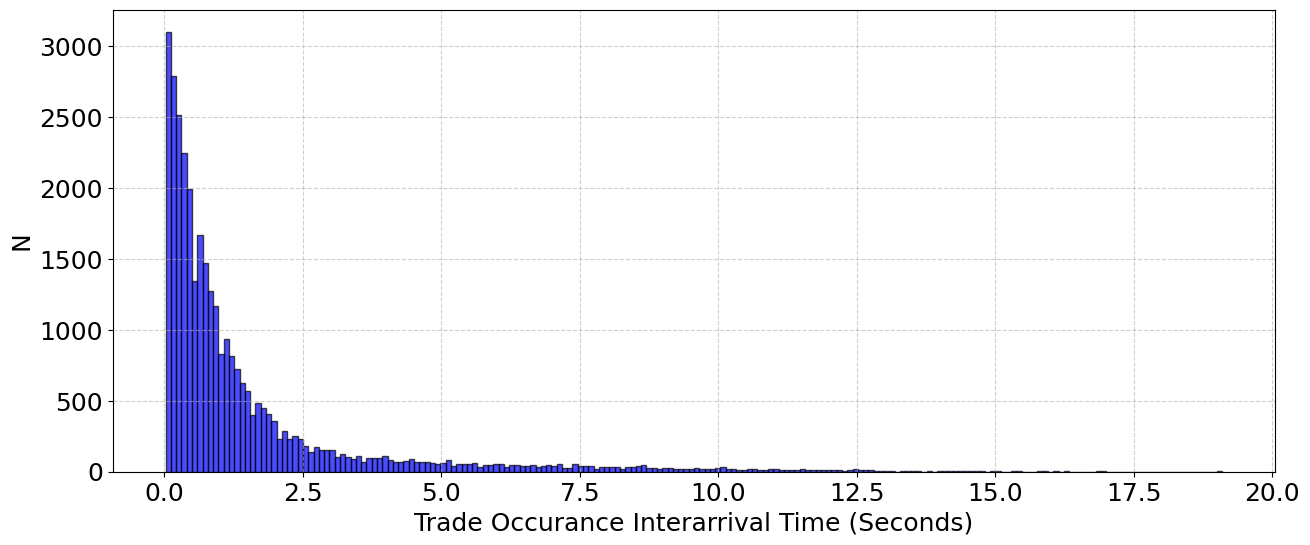

In [5]:
transactions = pd.read_csv('combined_tape.csv')
trade_times = transactions["timestamp"].values

inter_arrival_times = np.diff(trade_times)
inter_arrival_times = inter_arrival_times [inter_arrival_times > 0]  # Restrict data
inter_arrival_times = inter_arrival_times [inter_arrival_times < 100]  # Restrict data

# Plot histogram of inter-arrival times
plt.figure(figsize=(15, 6))
plt.hist(inter_arrival_times, bins=200, color='blue', alpha=0.7, edgecolor='black', density=False)
plt.xlabel("Trade Occurance Interarrival Time (Seconds)")
plt.ylabel("N")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [22]:
transactions = pd.read_csv('combined_tape.csv')
transactions.head(1000)

,session,timestamp,price
0,Trd,3.275,90
0,Trd,3.850,104
0,Trd,5.225,112
0,Trd,5.625,117
0,Trd,6.600,134
...,...,...,...
30,Trd,10.175,170
30,Trd,11.125,190
30,Trd,11.350,167
30,Trd,12.025,193


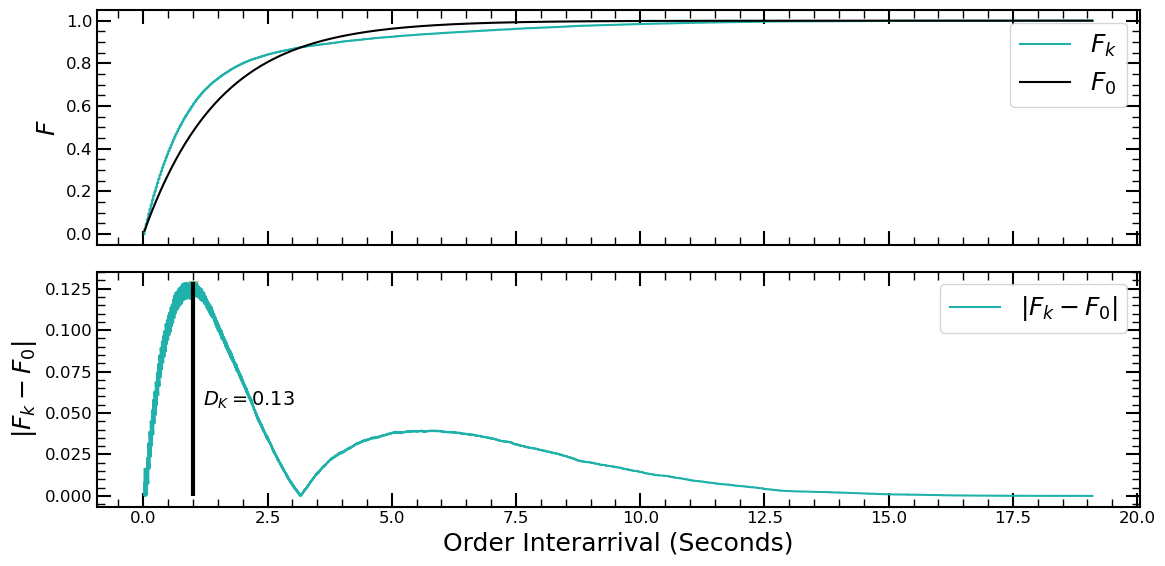

KS Statistic: 0.1288
P-Value: 1e-16
Reject the null hypothesis: Trades deviate from a Poisson process.


In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

filtered_data = inter_arrival_times #[inter_arrival_times < 5]  # Restrict data

# === Compute Theoretical CDF (Exponential Fit) ===
x = np.linspace(min(inter_arrival_times), max(inter_arrival_times), 100)
sorted_data = np.sort(filtered_data)
N = len(sorted_data)
lambda_hat = 1 / np.mean(filtered_data)
exp_dist = stats.expon(scale=1 / lambda_hat)
theoretical_cdf = exp_dist.cdf(sorted_data)

# === Compute KS Test ===
D_statistic, p_value = stats.kstest(filtered_data, exp_dist.cdf)
p_value = max(p_value, 1e-16)
# === Compute Kolmogorov-Smirnov Confidence Bands ===
def ks_confidence_band(N, alpha=0.05):
    """Compute KS confidence bands centered around F0."""
    c_alpha = stats.kstwobign.ppf(1 - alpha)  # Critical value
    margin = c_alpha / np.sqrt(N)  # Compute confidence interval width
    return margin

# Compute confidence intervals around the theoretical CDF
margin_95 = ks_confidence_band(N, alpha=0.05)
margin_99 = ks_confidence_band(N, alpha=0.01)
lower_95, upper_95 = np.clip(theoretical_cdf - margin_95, 0, 1), np.clip(theoretical_cdf + margin_95, 0, 1)
lower_99, upper_99 = np.clip(theoretical_cdf - margin_99, 0, 1), np.clip(theoretical_cdf + margin_99, 0, 1)

# === Generate KS Test Plot ===
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# === Upper Plot: Empirical vs Theoretical CDF ===
axes[0].plot(sorted_data, np.arange(1, N + 1) / N, label=r"$F_k$", color="lightseagreen")
axes[0].plot(sorted_data, theoretical_cdf, label=r"$F_0$", color="black")

#axes[0].fill_between(sorted_data, lower_99, upper_99, color='gray', alpha=0.3, label="99% CI")
#axes[0].fill_between(sorted_data, lower_95, upper_95, color='gray', alpha=0.5, label="95% CI")

axes[0].set_ylabel(r"$F$")
axes[0].legend()

# === Lower Plot: KS Statistic Difference ===
empirical_cdf = np.arange(1, N + 1) / N
ks_diff = np.abs(empirical_cdf - theoretical_cdf)

axes[1].plot(sorted_data, ks_diff, label=r"$|F_k - F_0|$", color="lightseagreen")
# Find the max KS difference point
max_diff_index = np.argmax(ks_diff)
max_x = sorted_data[max_diff_index]  # X value at max difference
max_y = ks_diff[max_diff_index]  # Y value at max difference

# Plot a vertical line at the max point with a cap
axes[1].vlines(max_x, 0, max_y, color='black', linestyle='solid', linewidth=3)
axes[1].scatter(max_x, max_y, color='darkseagreen', s=50, marker='_', linewidth=2)  # Cap marker

# Annotate the maximum point
offset = max_y * 0.05
offset_x = max_x + 0.001
axes[1].text(offset_x *1.2, max_y - offset * 12, f"$D_K={D_statistic:.2f}$", fontsize=14, color='black', ha='left', va='bottom')


axes[1].set_ylabel(r"$|F_k - F_0|$")
axes[1].legend()
axes[1].minorticks_on()
axes[0].minorticks_on()
axes[0].tick_params(axis='both', which='major', direction='in', length=10, width=1.5, labelsize=12,
                    top=True, bottom=True, left=True, right=True)
axes[0].tick_params(axis='both', which='minor', direction='in', length=6, width=1,
                    top=True, bottom=True, left=True, right=True)
axes[1].tick_params(axis='both', which='major', direction='in', length=10, width=1.5, labelsize=12,
                    top=True, bottom=True, left=True, right=True)
axes[1].tick_params(axis='both', which='minor', direction='in', length=6, width=1,
                    top=True, bottom=True, left=True, right=True)


# Apply thicker border edges to both subplots
for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)  # Adjust thickness (2 is thicker, increase if needed)
        


plt.xlabel("Order Interarrival (Seconds)")
#plt.xlim(0, 1)  # Restrict x-axis to 0.1
plt.tight_layout()
plt.show()

# Print KS Test Results
print(f"KS Statistic: {D_statistic:.4f}")
print(f"P-Value: {p_value:.4g}")
if p_value < 0.05:
    print("Reject the null hypothesis: Trades deviate from a Poisson process.")
else:
    print("Fail to reject the null hypothesis: Trades are consistent with a Poisson process.")





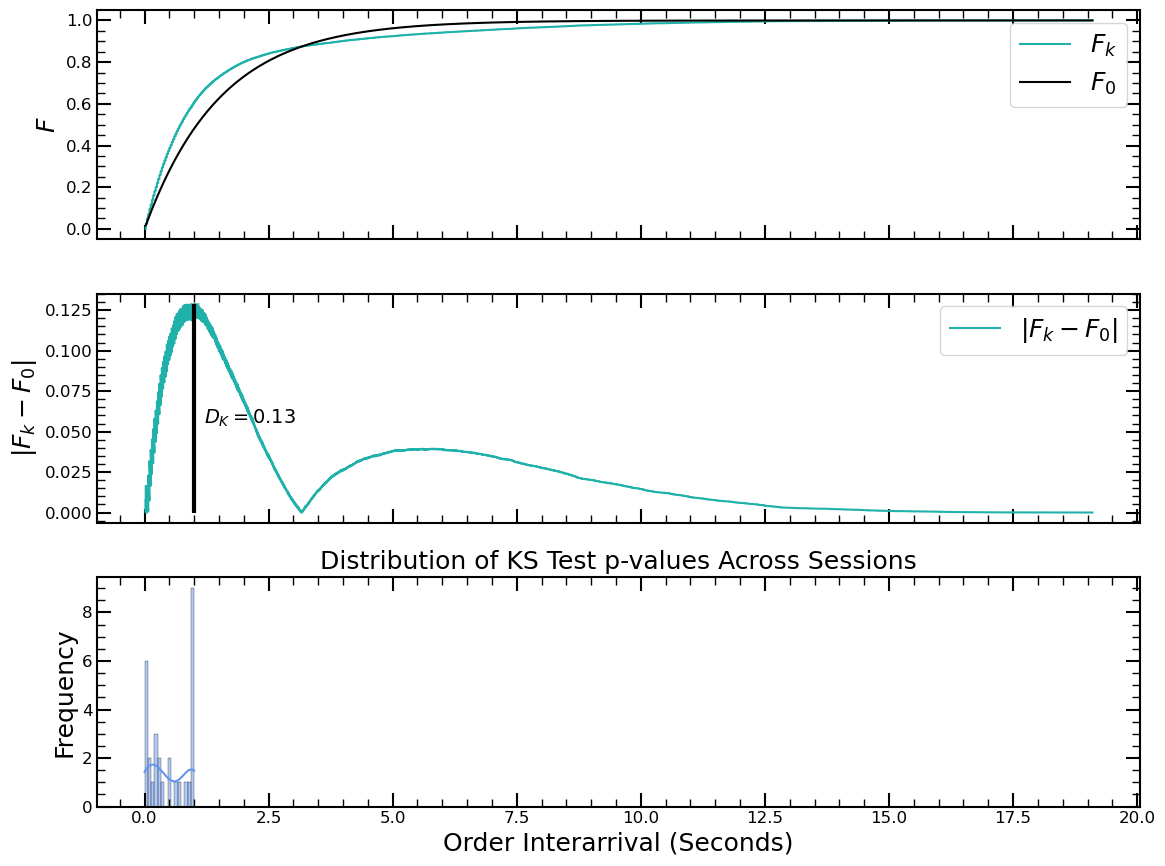

Single-session KS Statistic: 0.1288
Single-session P-Value: 1e-16
Reject the null hypothesis: Trades deviate from a Poisson process.


In [17]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# --- Example data for a single session (for the first two subplots) ---
filtered_data = inter_arrival_times  # Your interarrival times for one session
sorted_data = np.sort(filtered_data)
N = len(sorted_data)
lambda_hat = 1 / np.mean(filtered_data)
exp_dist = stats.expon(scale=1 / lambda_hat)
theoretical_cdf = exp_dist.cdf(sorted_data)

# --- Compute KS Test for this session ---
D_statistic, p_value_single = stats.kstest(filtered_data, exp_dist.cdf)
p_value_single = max(p_value_single, 1e-16)

# --- (Optional) Compute KS Confidence Bands ---
def ks_confidence_band(N, alpha=0.05):
    c_alpha = stats.kstwobign.ppf(1 - alpha)  # Critical value
    margin = c_alpha / np.sqrt(N)
    return margin

margin_95 = ks_confidence_band(N, alpha=0.05)
margin_99 = ks_confidence_band(N, alpha=0.01)
lower_95 = np.clip(theoretical_cdf - margin_95, 0, 1)
upper_95 = np.clip(theoretical_cdf + margin_95, 0, 1)
lower_99 = np.clip(theoretical_cdf - margin_99, 0, 1)
upper_99 = np.clip(theoretical_cdf + margin_99, 0, 1)

# --- Example p-value list from multiple sessions ---
# For demonstration purposes, let’s assume we already computed these for each session.
# Replace the following simulated p-values with your actual list.
p_values = np.random.beta(0.5, 0.5, size=30)  # 30 sample p-values, for example

# --- Create a Figure with 3 Subplots ---
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True,
                         gridspec_kw={'height_ratios': [1, 1, 1]})

# --- Panel 1: Empirical vs Theoretical CDF ---
axes[0].plot(sorted_data, np.arange(1, N + 1) / N, label=r"$F_k$", color="lightseagreen")
axes[0].plot(sorted_data, theoretical_cdf, label=r"$F_0$", color="black")
# If desired, you can uncomment to show confidence bands:
# axes[0].fill_between(sorted_data, lower_99, upper_99, color='gray', alpha=0.3, label="99% CI")
# axes[0].fill_between(sorted_data, lower_95, upper_95, color='gray', alpha=0.5, label="95% CI")
axes[0].set_ylabel(r"$F$")
axes[0].legend()
axes[0].minorticks_on()

# --- Panel 2: KS Statistic Difference ---
empirical_cdf = np.arange(1, N + 1) / N
ks_diff = np.abs(empirical_cdf - theoretical_cdf)
axes[1].plot(sorted_data, ks_diff, label=r"$|F_k - F_0|$", color="lightseagreen")
max_diff_index = np.argmax(ks_diff)
max_x = sorted_data[max_diff_index]
max_y = ks_diff[max_diff_index]
axes[1].vlines(max_x, 0, max_y, color='black', linestyle='solid', linewidth=3)
axes[1].scatter(max_x, max_y, color='darkseagreen', s=50, marker='_', linewidth=2)
offset = max_y * 0.05
offset_x = max_x + 0.001
axes[1].text(offset_x * 1.2, max_y - offset * 12, f"$D_K={D_statistic:.2f}$", fontsize=14, color='black', ha='left', va='bottom')
axes[1].set_ylabel(r"$|F_k - F_0|$")
axes[1].legend()
axes[1].minorticks_on()

# --- Panel 3: Distribution of P-values ---
sns.histplot(p_values, bins=15, kde=True, color="cornflowerblue", ax=axes[2])
axes[2].set_xlabel("Order Interarrival (Seconds)")  # Shared x-axis label
axes[2].set_ylabel("Frequency")
axes[2].set_title("Distribution of KS Test p-values Across Sessions")
axes[2].minorticks_on()

# --- Adjust tick parameters and spine thickness for all axes ---
for ax in axes:
    ax.tick_params(axis='both', which='major', direction='in', length=10, width=1.5, labelsize=12,
                   top=True, bottom=True, left=True, right=True)
    ax.tick_params(axis='both', which='minor', direction='in', length=6, width=1, top=True, bottom=True, left=True, right=True)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

# Print the KS test result for the single session plotted in panels 1 & 2:
print(f"Single-session KS Statistic: {D_statistic:.4f}")
print(f"Single-session P-Value: {p_value_single:.4g}")
if p_value_single < 0.05:
    print("Reject the null hypothesis: Trades deviate from a Poisson process.")
else:
    print("Fail to reject the null hypothesis: Trades are consistent with a Poisson process.")


/var/folders/x7/vjyxn4513wgcl1bqzb17849r0000gn/T/ipykernel_7718/2333489029.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


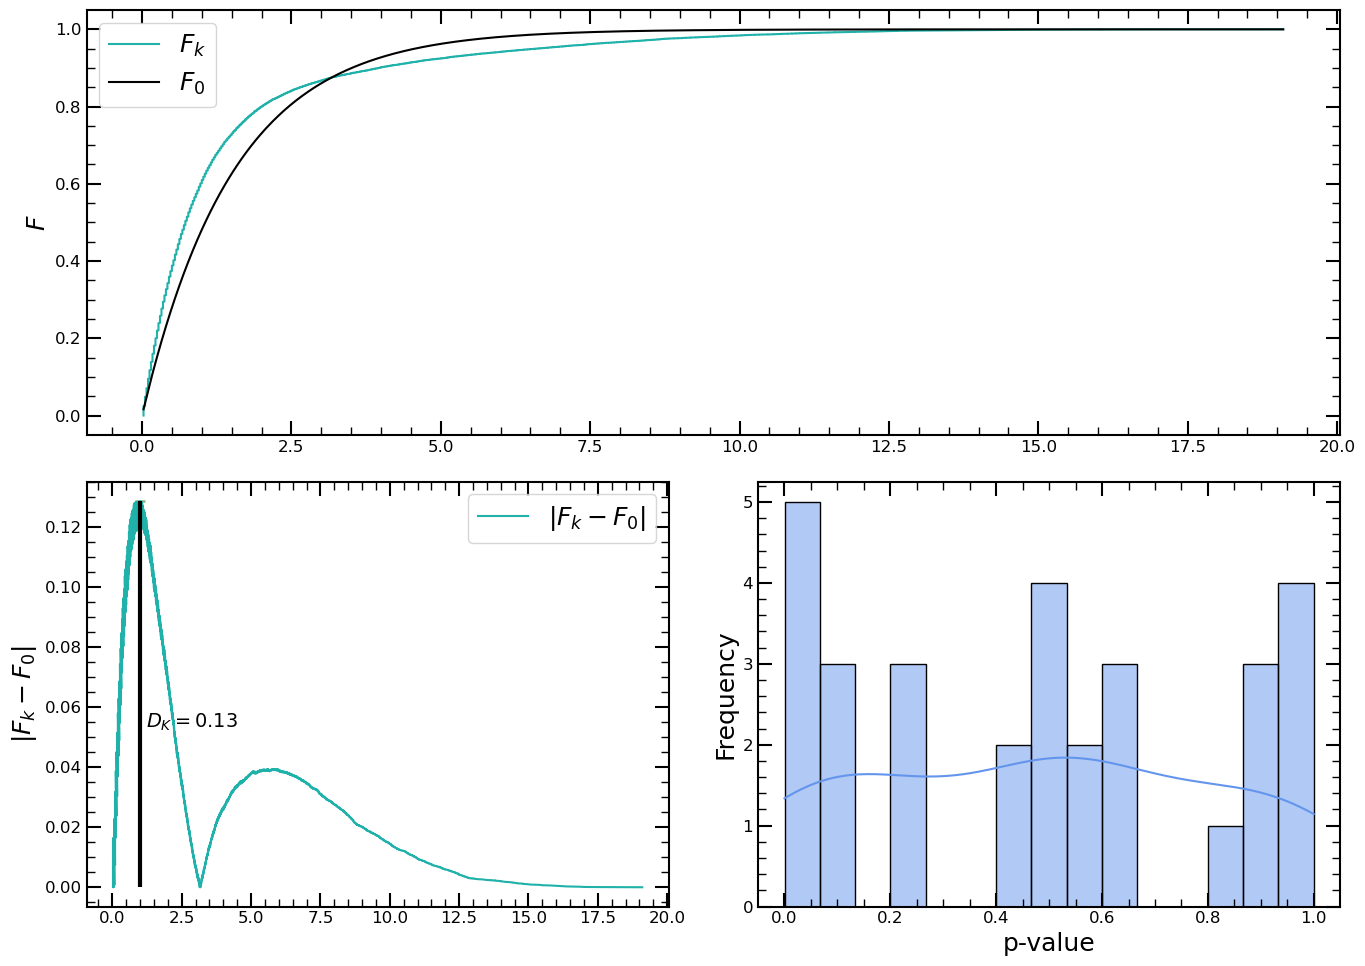

Single-session KS Statistic: 0.1288
Single-session P-Value: 1e-16
Reject the null hypothesis: Trades deviate from a Poisson process.


In [24]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# --- Example data for a single session (for the top and left bottom plots) ---
filtered_data = inter_arrival_times  # Your interarrival times for one session
sorted_data = np.sort(filtered_data)
N = len(sorted_data)
lambda_hat = 1 / np.mean(filtered_data)
exp_dist = stats.expon(scale=1 / lambda_hat)
theoretical_cdf = exp_dist.cdf(sorted_data)

# --- Compute KS Test for this session ---
D_statistic, p_value_single = stats.kstest(filtered_data, exp_dist.cdf)
p_value_single = max(p_value_single, 1e-16)

# --- Compute KS Statistic Difference ---
empirical_cdf = np.arange(1, N + 1) / N
ks_diff = np.abs(empirical_cdf - theoretical_cdf)
max_diff_index = np.argmax(ks_diff)
max_x = sorted_data[max_diff_index]
max_y = ks_diff[max_diff_index]

# --- Assume we have a list "p_values" from multiple sessions for the KS test ---
# Replace the following with your actual per-session p-value list.
p_values = np.random.beta(0.5, 0.5, size=30)

# --- Create a Figure with GridSpec: Top row: full width; Bottom row: two side-by-side plots ---
fig = plt.figure(constrained_layout=True, figsize=(14, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# --- Top Plot: Empirical vs Theoretical CDF spanning both columns ---
ax_top = fig.add_subplot(gs[0, :])
ax_top.plot(sorted_data, empirical_cdf, label=r"$F_k$", color="lightseagreen")
ax_top.plot(sorted_data, theoretical_cdf, label=r"$F_0$", color="black")
ax_top.set_ylabel(r"$F$")
ax_top.legend()
ax_top.minorticks_on()

# --- Bottom Left Plot: KS Statistic Difference (DK plot) ---
ax_left = fig.add_subplot(gs[1, 0])
ax_left.plot(sorted_data, ks_diff, label=r"$|F_k - F_0|$", color="lightseagreen")
ax_left.vlines(max_x, 0, max_y, color='black', linestyle='solid', linewidth=3)
ax_left.scatter(max_x, max_y, color='darkseagreen', s=50, marker='_', linewidth=2)
offset = max_y * 0.05
offset_x = max_x + 0.001
ax_left.text(offset_x * 1.2, max_y - offset * 12, f"$D_K={D_statistic:.2f}$", fontsize=14, color='black', ha='left', va='bottom')
ax_left.set_ylabel(r"$|F_k - F_0|$")
ax_left.legend()
ax_left.minorticks_on()

# --- Bottom Right Plot: Distribution of KS Test p-values ---
ax_right = fig.add_subplot(gs[1, 1])
sns.histplot(p_values, bins=15, kde=True, color="cornflowerblue", ax=ax_right)
ax_right.set_xlabel("p-value")
ax_right.set_ylabel("Frequency")
ax_right.minorticks_on()

# --- Apply common formatting to all axes (if desired) ---
for ax in [ax_top, ax_left, ax_right]:
    ax.tick_params(axis='both', which='major', direction='in', length=10, width=1.5, labelsize=12,
                   top=True, bottom=True, left=True, right=True)
    ax.tick_params(axis='both', which='minor', direction='in', length=6, width=1, top=True, bottom=True, left=True, right=True)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

# Print the KS test result for the single session plotted in ax_top and ax_left:t
print(f"Single-session KS Statistic: {D_statistic:.4f}")
print(f"Single-session P-Value: {p_value_single:.4g}")
if p_value_single < 0.05:
    print("Reject the null hypothesis: Trades deviate from a Poisson process.")
else:
    print("Fail to reject the null hypothesis: Trades are consistent with a Poisson process.")
